# Importing Dependencies

In [85]:
# Task B2
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os

# Task B3
import plotly.graph_objects as go
import plotly.express as px

# Task B4
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,SimpleRNN,LSTM, GRU, Dense, Dropout
import matplotlib.pyplot as plt
import sys

# Task B5
from tensorflow.keras import metrics

# Task B7
import tensorflow as tf

# Hyperparameters

In [86]:
# Task B2
TICKER = "AAPL"
START_DATE = "2010-01-01"
END_DATE = "2022-12-31"
LOOK_UP_DAYS = 20      
TRAINING_RATIO = 0.8    # 0.7 == 70%
SCALE_DATA = True
SCALING_METHOD = "MinMax"       # MinMax, Standard

# Task B3
TRADING_PERIOD = 60
CONSECUTIVE_DAYS = 300

# Task B4
NUMBER_OF_LAYER = 3
NUMBER_OF_HIDDEN_UNITS = 80
MODEL_NAME = "RNN"      ## "RNN". "LSTM", "GRU"
DROP_OUT_RATE = 0     ## dropout rate in [0,1]
NUMBER_OF_EPOCHS = 30
BATCH_SIZE = 32
FEATURE_PREDICT = "Close"    ## "Open", "High", "Close", "Low" 
LOSS_FUNCTION = "huber_loss" ## "mean_squared_error", "mean_absolute_error", "huber_loss"
OPTIMIZER = "adam"  ## "adam", "RMSprop", "SGD"

# Task B5
K_SEQUENCE = 20
START_TEST_DATE = "2024-01-01"
END_TEST_DATE = "2024-03-31"

# Task B2: DATA PROCESSING 1

## Scaling dataset

In [87]:
def DataScaler(stock_data, scaling_method=SCALING_METHOD):

    DatasetScaler = None
    ColumnScalers = {

    }
    if scaling_method == "MinMax":
        DatasetScaler = preprocessing.MinMaxScaler()
        
    
    elif scaling_method == "Standard":
        DatasetScaler = preprocessing.StandardScaler()

    
    # Learn the whole dataset
    col_names = stock_data.columns
    features = stock_data[col_names]
    DatasetScaler.fit(features.values)
    features = DatasetScaler.transform(features.values)
    scaledDataFrame = pd.DataFrame(features, columns = col_names)
    scaledDataFrame.index = stock_data.index
    
    for column in col_names:
        column_scaler = None
        if scaling_method == "MinMax":
            column_scaler = preprocessing.MinMaxScaler()
        elif scaling_method == "Standard":
            column_scaler = preprocessing.StandardScaler()
        column_scaler.fit(stock_data[column].values.reshape(-1,1))
        ColumnScalers[column] = column_scaler

    return scaledDataFrame, DatasetScaler, ColumnScalers


## Loading Data Function

In [88]:
def DataLoader(ticker=TICKER, start_date=START_DATE, end_date=END_DATE, scale=SCALE_DATA, scaling_method=SCALING_METHOD):
    '''
    ticker: is the code of the target ticker
    start_date: a start date string with format YYYY/MM/DD
    end_date: an end date string with format YYYY/MM/DD
    scale: a boolean value, True by default
    scaling_method: MinMax(by default), Standard.
    '''

    # result
    result = {
        "dataset": None,
        "datasetScaler": None,
        "columnScalers": None
    }

    # processing the input parameters
    start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")


    # creating necessary folder
    if not os.path.isdir("results"):
        os.mkdir("results")
    
    if not os.path.isdir("data"):
        os.mkdir("data")


    
    # checking if the data is already downloaded 
    ## Get a list of files in the directory
    files = os.listdir("data")
    ## Check each file in the directory
    data = None
    for file_name in files:
        ## if we already downloaded the ticket data
        if file_name.startswith(ticker) and file_name.endswith(".csv"):
            ### Read the file 
            file_path = os.path.join("data", f"{ticker}.csv")
            data = pd.read_csv(file_path, parse_dates=['Date'])
            break

    ## else, we gonna download the stock data
    if data is None:
        stock_data = yf.download(ticker, start_date, end_date)
        file_path = os.path.join("data", f"{ticker}.csv")
        stock_data.to_csv(file_path)
        data = pd.read_csv(file_path, parse_dates=['Date'])

    # if the given time is included in the file, we just take the nessecary dataframe
    if data.head(1)["Date"].values[0] <= np.datetime64(start_date) and data.tail(1)["Date"].values[0] >= np.datetime64(end_date):
        data = data[(data['Date'] >= pd.to_datetime(start_date)) & (data['Date'] <= pd.to_datetime(end_date))]
        print("Local Stock Data is enough for requirements, do not need to download")
    else: 
        stock_data = yf.download(ticker, start_date, end_date)
        file_path = os.path.join("data", f"{ticker}.csv")
        stock_data.to_csv(file_path)
        data = pd.read_csv(file_path, parse_dates=['Date'])
        print("Local Stock Data is not enough for requirements, continuing downloading...")

    # Setting Date as Index
    data.set_index('Date', inplace=True)

    # Scale Data
    if scale:
        data, scaler, column_scalers = DataScaler(data, scaling_method)
        result["dataset"] = data
        result["datasetScaler"] = scaler
        result["columnScalers"] = column_scalers
        return result

    result["dataset"] = data
    
    return result

## Splitting Dataset

In [89]:
def datasetSplitter(dataset: pd.DataFrame, look_up_days=LOOK_UP_DAYS, 
        training_ratio=TRAINING_RATIO,  
        feature_columns=['Open','High','Low','Close','Adj Close','Volume'], k_sequence=K_SEQUENCE):
    '''
    dataset: a Pandas Dataframe
    training_ratio: is equal to TRAINING_RATION constant
    '''
    # result
    splitResult = {
        "X_training_set": None,
        "Y_training_set": None,
    }

    x_data = []
    y_data = []
    total_records = len(dataset)
    for day in range(look_up_days, total_records - k_sequence):
        data_points = []
        y_data.append(dataset[FEATURE_PREDICT][day:day+k_sequence])

        for j in range(day - look_up_days, day):
            input_feature_x = []
        
            for column in feature_columns:
                if column == FEATURE_PREDICT:
                    continue
                input_feature_x.append(dataset[column].values.reshape(-1, 1)[j, 0])

            data_points.append(input_feature_x)
        x_data.append(data_points)
    splitResult["X_training_set"], splitResult["Y_training_set"] = x_data, y_data
    
    splitResult["X_training_set"] = np.array(splitResult["X_training_set"])
    splitResult["Y_training_set"] = np.array(splitResult["Y_training_set"])
    
    
    return splitResult


## Data Processing 1 (FULL)

A function to load and process a dataset with multiple features with the following requirements: 

+ Specify the start date and the end date for the whole 
dataset as inputs. 
+ Allowing you to deal with the NaN issue in the data
+ Splitting dataset according to some specified ratio of train/test
+ Storing the downloaded data on your local machine for future uses
+ Allowing you to have an option to scale your feature columns and store the scalers in a data structure to allow future access to these scalers.

In [90]:
def Data_Processing_1():
    dataLoader = DataLoader()

    scaledStockData = dataLoader["dataset"]
    datasetScaler = dataLoader["datasetScaler"]
    columnScalers = dataLoader["columnScalers"]
    
    dataset = datasetSplitter(dataset=scaledStockData)
    
    print("Loaded Done!\nThe result is a tuple as below:\n")
    print("(dataset, scaledStockData, datasetScaler, columnScalers), where:\n")
    print("dataset is a dictionary as below:")
    print('''{
        "X_training_set": <class 'numpy.ndarray'>,
        "Y_training_set": <class 'numpy.ndarray'>,
    }\n''')
    print("scaledStockData is a Pandas Dataframe of the Stock Ticker (scaled)\n")
    print("datasetScaler is the Scaler of the dataset\n")
    print("columnScalers is a dictionary: each key is a DataFrame Feature('Open', 'High', etc.) and the correspond value is a scaler of that feature")
    return dataset, scaledStockData, datasetScaler, columnScalers
    

# Task B5: Machine Learning 2

### Inverse Data

In [91]:
def datasetInverser(scaledStockData, datasetScaler):
    
    # Getting Column name
    col_names = scaledStockData.columns
    # Inversing the dataframe
    re_scaled_features = datasetScaler.inverse_transform(scaledStockData)
    re_scaled_stock_data = pd.DataFrame(re_scaled_features, columns = col_names)
    # Assigning index to the rescaled_data
    re_scaled_stock_data.index = scaledStockData.index


    ## A Pandas Dataframe
    return re_scaled_stock_data
       

### Inversing A Column in the Dataset

In [92]:
def columnInverser(columnData, ColumnScaler):
    '''columnData: an np.array'''
    # transform the shape of the data
    reshaped_data = columnData.reshape(-1, 1)
    result = ColumnScaler.inverse_transform(reshaped_data)
    return result

### Plotting the Loss Error

In [93]:
def trainingErrorPloter(modelType, loss, validation):
    fig = plt.figure(figsize=(4, 3)) 
    plt.plot(loss, c="red", label = "training set")
    plt.plot(validation, c="blue", label = "validation set")
    plt.legend()
    plt.title(f"Loss Plotting of {modelType} Model")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    return fig

### Plotting Metrics

In [94]:
def MSE_Ploter(modelType ,mse):
    fig = plt.figure(figsize=(4, 3)) 
    plt.plot(mse, c="blue", label = f"MSE")
    plt.legend()
    plt.title(f"Evaluation on {modelType} Model")
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    return fig

### Plotting Predicted Result

In [95]:
def predictedResultPloter(actual_value, RNN_predicted_value, LSTM_predicted_value, GRU_predicted_result, AdvancedLSTM_predicted_result, testingStockData, feature=FEATURE_PREDICT):
    fig = plt.figure(figsize=(15, 8)) 
    plt.plot(testingStockData.index, actual_value, c="orange", label = f"{feature} Price (Actual)")
    plt.plot(testingStockData.index, RNN_predicted_value, c="red", label = f"RNN--{feature} Price (Predicted)")
    plt.plot(testingStockData.index, LSTM_predicted_value, c="green", label = f"LSTM--{feature} Price (Predicted)")
    plt.plot(testingStockData.index, GRU_predicted_result, c="blue", label = f"GRU--{feature} Price (Predicted)")
    plt.plot(testingStockData.index, AdvancedLSTM_predicted_result, c="gray", label = f"AdvancedLSTM--{feature} Price (Predicted)")
    plt.legend()
    plt.title(f"Testing on {TICKER} shared price, LOOK_UP_DAYS={LOOK_UP_DAYS}, Predicting the sequential of {K_SEQUENCE} days")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    return fig

### Result Saver

In [96]:
def resultSaver(RNNerrorFig, RNNmetrics_MSE, LSTMerrorFig, LSTMmetrics_MSE, GRUerrorFig, GRUmetrics_MSE, AdvancedLSTM_errorFig, AdvancedLSTM_metrics_MSE,predictResult):
    # Get a list of foler in the results folders
    folders = os.listdir("results")


    # Creating a new folder to store the training infomation
    latestFolderName = "Evaluation_K"
    if K_SEQUENCE < 10:
        latestFolderName += ("0" + str(K_SEQUENCE))
    else:
        latestFolderName += str(K_SEQUENCE)
    evaluation_path = os.path.join("results", latestFolderName)
    os.makedirs(evaluation_path)
    # Saving Fig
    RNNerrorFig.savefig(os.path.join(evaluation_path, "RNN_error.png"))
    RNNmetrics_MSE.savefig(os.path.join(evaluation_path, "RNN_metrics_MSE.png"))


    LSTMerrorFig.savefig(os.path.join(evaluation_path, "LSTM_error.png"))
    LSTMmetrics_MSE.savefig(os.path.join(evaluation_path, "LSTM_metrics_MSE.png"))


    GRUerrorFig.savefig(os.path.join(evaluation_path, "GRU_error.png"))
    GRUmetrics_MSE.savefig(os.path.join(evaluation_path, "GRU_metrics_MSE.png"))

    AdvancedLSTM_errorFig.savefig(os.path.join(evaluation_path, "AdvancedLSTM_error.png"))
    AdvancedLSTM_metrics_MSE.savefig(os.path.join(evaluation_path, "AdvancedLSTM_metrics_MSE.png"))

   
    predictResult.savefig(os.path.join(evaluation_path, "PredictResult.png"))

    with open(os.path.join(evaluation_path, "Configuration.txt"), 'w') as file:
        content = f'''
        NUMBER_OF_LAYER = {NUMBER_OF_LAYER} \n
        NUMBER_OF_HIDDEN_UNITS = {NUMBER_OF_HIDDEN_UNITS} \n
        NUMBER_OF_EPOCHS = {NUMBER_OF_EPOCHS}\n
        BATCH_SIZE = {BATCH_SIZE}\n
        FEATURE_PREDICT = "{FEATURE_PREDICT}"\n    
        LOSS_FUNCTION = "{LOSS_FUNCTION}"\n 
        OPTIMIZER = "{OPTIMIZER}"\n  
        DROP_OUT_RATE = {DROP_OUT_RATE}    '''
        
        file.write(content)
        


### Recurrent Neural Networks (RNNs)

In [97]:
def RecurrentNeuralNetworks(InputLayer,layerNums=NUMBER_OF_LAYER,hidden_units=NUMBER_OF_HIDDEN_UNITS, loss_type=LOSS_FUNCTION, optimizerType=OPTIMIZER, dense_unit=K_SEQUENCE, activation=["tanh", "linear"], dropoutRate = DROP_OUT_RATE):
    model = Sequential()

    for i in range(layerNums):
        if i == (layerNums - 1):
            model.add(InputLayer)
            model.add(SimpleRNN(hidden_units, activation=activation[0]))
            model.add(Dropout(dropoutRate))
        else:
            model.add(SimpleRNN(hidden_units, activation=activation[0], return_sequences=True))
            model.add(Dropout(dropoutRate))

    model.add(Dense(units=dense_unit, activation=activation[1]))
    model.compile(loss=loss_type, metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError(), metrics.R2Score()], optimizer=optimizerType)
    return model

### Long Short Term Memory (LSTM)

In [98]:
def LongShortTermMemory(InputLayer, layerNums=NUMBER_OF_LAYER,hidden_units=NUMBER_OF_HIDDEN_UNITS, loss_type=LOSS_FUNCTION, optimizerType=OPTIMIZER, dense_unit=K_SEQUENCE, activation=["tanh", "linear"], dropoutRate = DROP_OUT_RATE):
    model = Sequential()

    for i in range(layerNums):
        if i == (layerNums - 1):
            model.add(InputLayer)
            model.add(LSTM(hidden_units, activation=activation[0]))
            model.add(Dropout(dropoutRate))
        else:
            model.add(LSTM(hidden_units, activation=activation[0], return_sequences=True))
            model.add(Dropout(dropoutRate))

    model.add(Dense(units=dense_unit, activation=activation[1]))
    model.compile(loss=loss_type, metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError(), metrics.R2Score()], optimizer=optimizerType)
    return model

### Gated Recurrent Unit (GRU)

In [99]:
def GatedRucurrentUnit(InputLayer, layerNums=NUMBER_OF_LAYER,hidden_units=NUMBER_OF_HIDDEN_UNITS, loss_type=LOSS_FUNCTION, optimizerType=OPTIMIZER, dense_unit=K_SEQUENCE, activation=["tanh", "linear"], dropoutRate = DROP_OUT_RATE):
    model = Sequential()

    for i in range(layerNums):
        if i == (layerNums - 1):
            model.add(InputLayer)
            model.add(GRU(hidden_units, activation=activation[0]))
            model.add(Dropout(dropoutRate))
        else:
            model.add(GRU(hidden_units, activation=activation[0], return_sequences=True))
            model.add(Dropout(dropoutRate))

    model.add(Dense(units=dense_unit, activation=activation[1]))
    model.compile(loss=loss_type, metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError(), metrics.R2Score()], optimizer=optimizerType)
    return model

### Testing Data Loader

In [100]:
def testingDataLoader(ticker=TICKER, start_date=START_TEST_DATE, end_date=END_TEST_DATE, end_train_date=END_DATE, scale=SCALE_DATA, scaling_method=SCALING_METHOD, k_days=K_SEQUENCE, feature=FEATURE_PREDICT, look_up_days=LOOK_UP_DAYS):
    result = {
        "testingStockData": None,
        "x_data": None,
        "y_scaled_test": None,
        "y_original_test": None,
        "columnScalers": None
    }
    
    real_stock_data = yf.download(ticker, start_date, end_date)
    # Getting the latest k_days records 
    real_stock_data = real_stock_data.tail(k_days)
    result["testingStockData"] = real_stock_data
    
    # Getting the last look_up_days records
    real_stock_data_back_then = yf.download(ticker, end_train_date, start_date)

    real_stock_data_back_then = real_stock_data_back_then.head(look_up_days)
    
    columns = real_stock_data_back_then.columns.tolist()
    # Scale Data
    if scale:
        x_data = []
        scaledData, scaler, column_scalers = DataScaler(real_stock_data_back_then, scaling_method)
        
        for day in range(look_up_days):
            data_point = []
            for column in columns:
                if column == feature:
                    continue

                data_point.append(scaledData[column].values[day])
            x_data.append(data_point)
        
        
        result["x_data"] = np.array(x_data)
        result["y_scaled_test"] = scaledData[feature].values
        result["y_original_test"] = real_stock_data[feature].values
        result["columnScalers"] = column_scalers
    
    else:
        x_data = []
        for day in range(look_up_days):
            data_point = []
            for column in columns:
                if column == feature:
                    continue

                data_point.append(real_stock_data_back_then[column].values[day])
            x_data.append(data_point)
        
        
        result["x_data"] = np.array(x_data)
        result["y_scaled_test"] = real_stock_data[feature].values
        result["y_original_test"] = real_stock_data[feature].values
        
    # Reshape the input data
    result["x_data"] = result["x_data"].reshape((1, look_up_days, 5))
    return result

### Training Function

In [101]:
def Train(RNNmodel, LSTMmodel, GRUmodel, advancedLSTMmodel, dataset, columnScalers, num_epoc=NUMBER_OF_EPOCHS, batch=BATCH_SIZE):
    

    ## Getting x_train, y_train, x_test, and y_test
    x_train = dataset["X_training_set"]
    y_train = dataset["Y_training_set"]


    # RNN training 
    RNN_training_result = RNNmodel.fit(x_train, y_train, epochs=num_epoc, batch_size=batch, validation_split=0.2)

    ## Plotting the error
    RNNerrorfig = trainingErrorPloter("RNN",RNN_training_result.history["loss"], RNN_training_result.history["val_loss"])
    
    ## Ploting the evaluation Result
    RNN_MSE_Fig = MSE_Ploter("RNN",RNN_training_result.history["mean_squared_error"])


    # LSTM training 
    LSTM_training_result = LSTMmodel.fit(x_train, y_train, epochs=num_epoc, batch_size=batch, validation_split=0.2)

    ## Plotting the error
    LSTMerrorfig = trainingErrorPloter("LSTM",LSTM_training_result.history["loss"], LSTM_training_result.history["val_loss"])
    
    ## Ploting the evaluation Result
    LSTM_MSE_Fig = MSE_Ploter("LSTM", LSTM_training_result.history["mean_squared_error"])


    # GRU training 
    GRU_training_result = GRUmodel.fit(x_train, y_train, epochs=num_epoc, batch_size=batch, validation_split=0.2)

    ## Plotting the error
    GRUerrorfig = trainingErrorPloter("GRU", GRU_training_result.history["loss"], GRU_training_result.history["val_loss"])
    
    ## Ploting the evaluation Result
    GRU_MSE_Fig = MSE_Ploter("GRU", GRU_training_result.history["mean_squared_error"])

    
    # Advanced LSTM training 
    advancedLSTM_training_result = advancedLSTMmodel.fit(x_train, y_train, epochs=num_epoc, batch_size=batch, validation_split=0.2)

    ## Plotting the error
    advancedLSTMerrorfig = trainingErrorPloter("advanced_LSTM",advancedLSTM_training_result.history["loss"], advancedLSTM_training_result.history["val_loss"])
    
    ## Ploting the evaluation Result
    advancedLSTM_MSE_Fig = MSE_Ploter("advanced_LSTM", advancedLSTM_training_result.history["mean_squared_error"])
    
    
    # Testing the result
    testingDatasetLoader = testingDataLoader()
    testing_stock_dataframe = testingDatasetLoader["testingStockData"]
    y_original = testingDatasetLoader["y_original_test"]
    x = testingDatasetLoader["x_data"]

    
    RNN_y_predicted = RNNmodel.predict(x)
    LSTM_y_predicted = LSTMmodel.predict(x)
    GRU_y_predicted = GRUmodel.predict(x)
    AdvancedLSTM_y_predicted = advancedLSTMmodel.predict(x)

    ## Reverse prediction if required
    if SCALE_DATA:
        RNN_y_predicted = RNN_y_predicted.reshape(K_SEQUENCE,)
        RNN_y_predicted = columnInverser(RNN_y_predicted, columnScalers[FEATURE_PREDICT])
        
        
        LSTM_y_predicted = LSTM_y_predicted.reshape(K_SEQUENCE,)
        LSTM_y_predicted = columnInverser(LSTM_y_predicted, columnScalers[FEATURE_PREDICT])
        
        GRU_y_predicted = GRU_y_predicted.reshape(K_SEQUENCE,)
        GRU_y_predicted = columnInverser(GRU_y_predicted, columnScalers[FEATURE_PREDICT])

        AdvancedLSTM_y_predicted = AdvancedLSTM_y_predicted.reshape(K_SEQUENCE,)
        AdvancedLSTM_y_predicted = columnInverser(AdvancedLSTM_y_predicted, columnScalers[FEATURE_PREDICT])


    
    # Plotting predicted result
    predictedResultFigure = predictedResultPloter(y_original, RNN_y_predicted, LSTM_y_predicted, GRU_y_predicted, AdvancedLSTM_y_predicted, testing_stock_dataframe) 
    
    resultSaver(RNNerrorfig, RNN_MSE_Fig, LSTMerrorfig, LSTM_MSE_Fig, GRUerrorfig, GRU_MSE_Fig, advancedLSTMerrorfig, advancedLSTM_MSE_Fig, predictedResultFigure)


In [102]:
dataset, scaledStockData, datasetScaler, ColumnScalers  = Data_Processing_1()

d:\DELL\Desktop\COS30018\COS30018\ProjectAssessment\TaskB1\myenv\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


Local Stock Data is not enough for requirements, continuing downloading...


Loaded Done!
The result is a tuple as below:

(dataset, scaledStockData, datasetScaler, columnScalers), where:

dataset is a dictionary as below:
{
        "X_training_set": <class 'numpy.ndarray'>,
        "Y_training_set": <class 'numpy.ndarray'>,
    }

scaledStockData is a Pandas Dataframe of the Stock Ticker (scaled)

datasetScaler is the Scaler of the dataset

columnScalers is a dictionary: each key is a DataFrame Feature('Open', 'High', etc.) and the correspond value is a scaler of that feature


# Task B7: Comprehensive extension and Independent Research

In [103]:
class ExpectationBiasLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ExpectationBiasLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        # Assuming 'inputs' shape is [batch, timesteps, features] = [?, 10, 5]
        # And Sequence is the entire inputs for simplicity
        Sequence = inputs
        output = []
        for State in range(1, inputs.shape[1] + 1):  # Starting from 1 to avoid division by zero
            input = inputs[:, State-1, :]  # Current state
            Beta_T = 1 / tf.cast(State, tf.float32)
            e_State = []
            for i in range(inputs.shape[-1]):  # Loop through features
                u_i = tf.reduce_mean(Sequence[:, :State, i], axis=1)  # Mean over the sequence up to current state
                e_i_t = (Beta_T * input[:, i]) + (1 - Beta_T) * u_i
                e_State.append(e_i_t)
            e_State = tf.stack(e_State, axis=1)
            output.append(e_State)
        output = tf.stack(output, axis=1)
        return output

def AdvancedLSTM(InputLayer,hidden_units=NUMBER_OF_HIDDEN_UNITS, loss_type=LOSS_FUNCTION, optimizerType=OPTIMIZER, dense_unit=K_SEQUENCE):
    expectation_layer = ExpectationBiasLayer()(InputLayer)
    lstm_layer = tf.keras.layers.LSTM(hidden_units, return_sequences=False)(expectation_layer)
    output_layer = tf.keras.layers.Dense(dense_unit)(lstm_layer)  

    model = tf.keras.Model(inputs=InputLayer, outputs=output_layer)
    model.compile(optimizer=optimizerType, loss=loss_type, metrics=[metrics.MeanSquaredError(), metrics.MeanAbsoluteError(), metrics.R2Score()])

    return model

In [104]:

def TaskB7_ComprehensiveExtension(dataset=dataset, column_scalers=ColumnScalers):

    inputLayer = tf.keras.Input(shape=(dataset["X_training_set"].shape[1],dataset["X_training_set"].shape[2]), batch_size=dataset["X_training_set"].shape[0])
    

    RNNmodel = RecurrentNeuralNetworks(inputLayer)


    LSTMmodel = LongShortTermMemory(inputLayer)
    

    GRUmodel = GatedRucurrentUnit(inputLayer)


    AdvancedLSTMmodel = AdvancedLSTM(inputLayer)
    ## Performing Training and getting result
    Train(RNNmodel, LSTMmodel, GRUmodel, AdvancedLSTMmodel, dataset, column_scalers)

Epoch 1/30
81/81 [==============================] - 3s 14ms/step - loss: 0.0067 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0607 - r2_score: -0.5736 - val_loss: 0.0447 - val_mean_squared_error: 0.0894 - val_mean_absolute_error: 0.2592 - val_r2_score: -4.5661
Epoch 2/30
81/81 [==============================] - 1s 10ms/step - loss: 2.9723e-04 - mean_squared_error: 5.9445e-04 - mean_absolute_error: 0.0184 - r2_score: 0.9310 - val_loss: 0.0365 - val_mean_squared_error: 0.0731 - val_mean_absolute_error: 0.2368 - val_r2_score: -3.5450
Epoch 3/30
81/81 [==============================] - 1s 8ms/step - loss: 2.2274e-04 - mean_squared_error: 4.4549e-04 - mean_absolute_error: 0.0157 - r2_score: 0.9483 - val_loss: 0.0301 - val_mean_squared_error: 0.0602 - val_mean_absolute_error: 0.2098 - val_r2_score: -2.7508
Epoch 4/30
81/81 [==============================] - 1s 8ms/step - loss: 2.3874e-04 - mean_squared_error: 4.7748e-04 - mean_absolute_error: 0.0165 - r2_score: 0.9446 - val_loss: 0.0

d:\DELL\Desktop\COS30018\COS30018\ProjectAssessment\TaskB1\myenv\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
d:\DELL\Desktop\COS30018\COS30018\ProjectAssessment\TaskB1\myenv\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 2s 2s/step


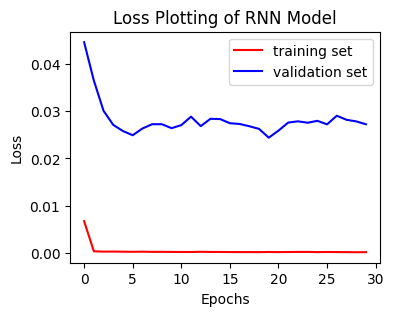

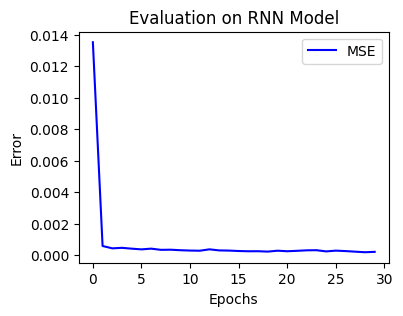

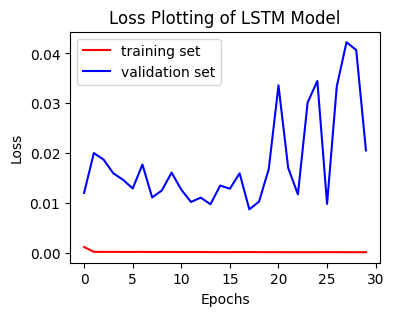

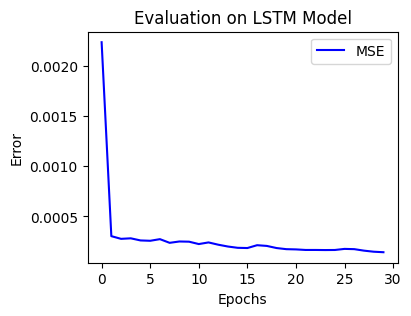

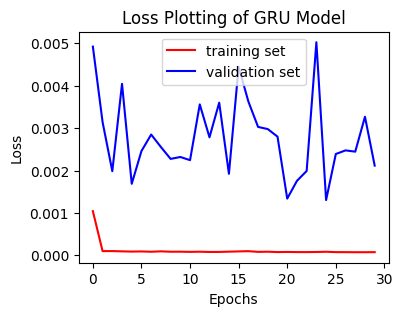

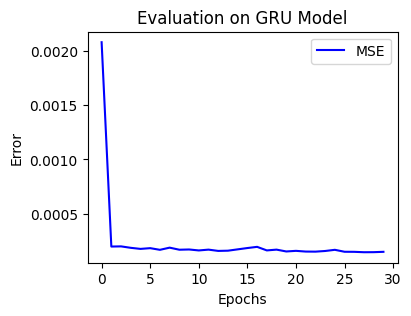

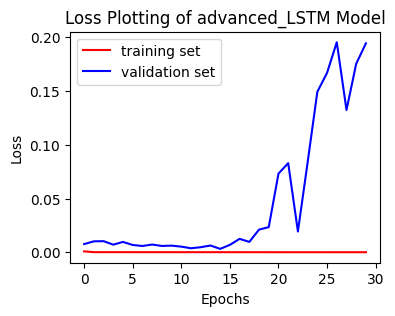

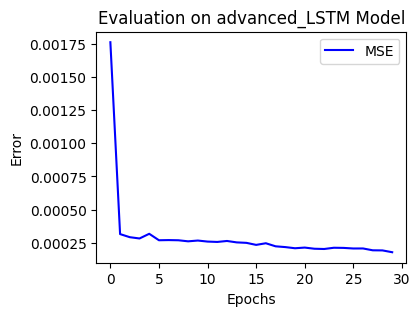

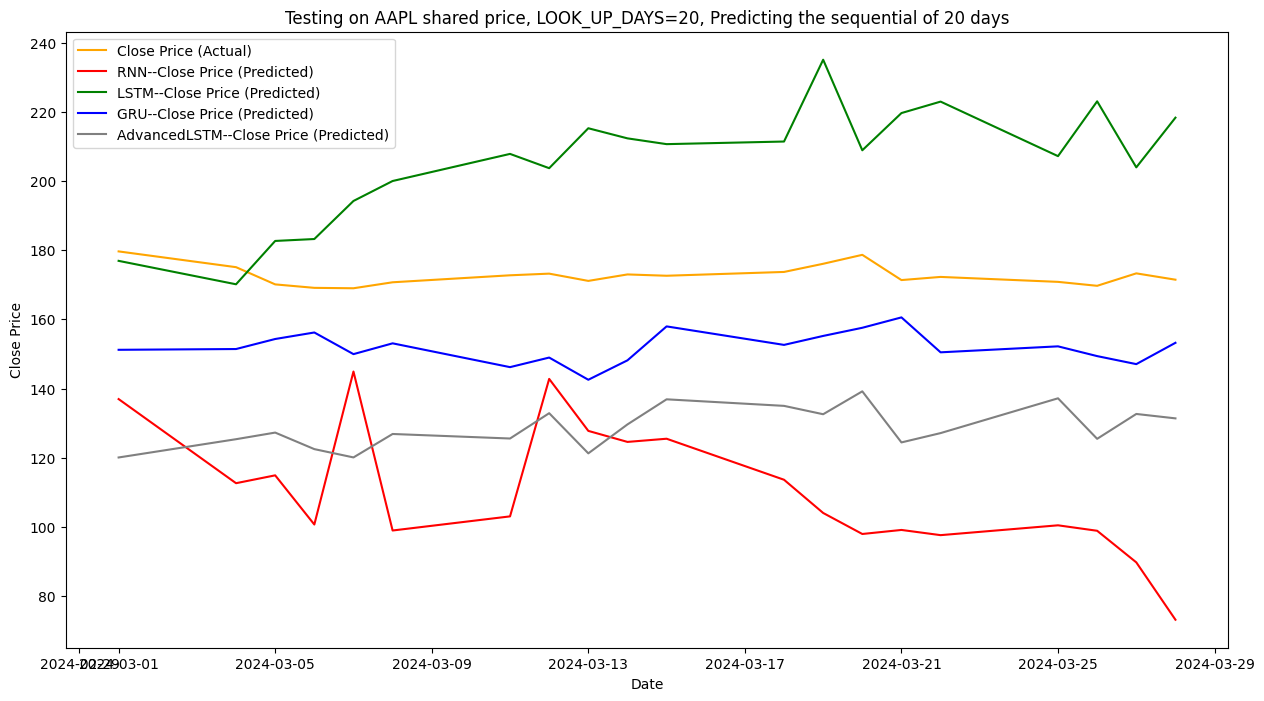

In [105]:
TaskB7_ComprehensiveExtension()